In [15]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import shdom
import glob
from scipy.ndimage import center_of_mass
import re




In [16]:

"""
Set settings
"""
wavelength = 0.672
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
vel_camera = 45 # m/s
camera_height = 6 #km
# A fly over from West to East (positive y-axis direction)
camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
camera_azimuth_list = [-90, -90, -90, -90, 0, 90, 90, 90, 90]

output_dir = 'experiments/Extinction_WIZ_dt10_truncated_velocity_0_0_9img_perspective/dynamic_medium'

# sun
sun_azimuth=65
sun_zenith=135

# solver
iter = 100

# Mie scattering for water droplets
mie = shdom.MiePolydisperse()
mie.read_table(file_path='../mie_tables/polydisperse/Water_672nm.scat')

Reading mie table from file: ../mie_tables/polydisperse/Water_672nm.scat


In [17]:
data_dir = '../synthetic_cloud_fields/WIZ_Clouds/'
format_ = 'BOMEX_1CLD_256x256x320_500CCNblowInv_10m_1sec_micro_256_*.txt'# load 
volumes_paths = sorted(glob.glob(data_dir + '/'+format_))

volumes_paths = volumes_paths[2::2]

In [18]:
# Rayleigh scattering for air molecules up to 20 km
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, camera_height, 20))
rayleigh = shdom.Rayleigh(wavelength=wavelength)
rayleigh.set_profile(temperature_profile.resample(air_grid))
air = rayleigh.get_scatterer()


def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv(volumes_paths[4])
com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])

L_list = (np.sign(camera_azimuth_list)) * (camera_height - com_z) * np.tan(np.deg2rad(camera_zenith_list) )

time_list = L_list *1e3 / vel_camera #sec
camera_position_list = np.zeros([L_list.shape[0],3])

# move the camera instead of the cloud
camera_position_list[:, 0] = com_x
camera_position_list[:, 1] = com_y + np.asarray(L_list)
camera_position_list[:, 2] = camera_height

In [19]:
resample=True
# grid = shdom.Grid(x=np.linspace(droplets.grid.xmin+0.5,droplets.grid.xmax-0.5,32),y=np.linspace(droplets.grid.ymin+0.5,droplets.grid.ymax-0.5,32),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax,48))
grid = shdom.Grid(x=np.linspace(droplets.grid.xmin,droplets.grid.xmax,26),y=np.linspace(droplets.grid.ymin,droplets.grid.ymax,26),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax,36))
temporary_scatterer_list = []
for volumes_path, time in zip(volumes_paths, time_list):
   # Generate a Microphysical medium
    droplets = shdom.MicrophysicalScatterer()
    droplets.load_from_csv(volumes_path)
    droplets.add_mie(mie)
    if resample:
        droplets.resample(grid)
    droplets = droplets.get_optical_scatterer(wavelength)
    # droplets.grid = shdom.Grid(x=np.linspace(0,droplets.grid.xmax-0.5*2,32),y=np.linspace(0,droplets.grid.ymax-0.5*2,32),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax,48))
    # droplets1 = droplets.get_optical_scatterer(wavelength)
    ext1 = droplets.extinction.data 
    ext1 /= 30
    # lwc = droplets.lwc.data
    # lwc /= 30 
    # droplets2 = droplets.get_optical_scatterer(wavelength)
    # ext2 = droplets2.extinction.data 
    temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,time))
    
# grid = shdom.Grid(x=np.linspace(0,droplets.grid.xmax-0.5*2,32),y=np.linspace(0,droplets.grid.ymax-0.5*2,32),z=np.linspace(droplets.grid.zmin,droplets.grid.zmax,48))


Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.01]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value
Minimum medium effective radius [0.00] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting ex

In [20]:
dynamic_scatterer = shdom.DynamicScatterer()
dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)
dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air.resample(grid))

In [21]:
scene_params = shdom.SceneParameters(
    wavelength=mie.wavelength,
    source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith)
)
numerical_params = shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16)

dynamic_solver = shdom.DynamicRteSolver(scene_params=scene_params,numerical_params=numerical_params)
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter)

In [22]:
projections = shdom.MultiViewProjection()

for camera_azimuth,camera_zenith,camera_position in zip(camera_azimuth_list,camera_zenith_list,camera_position_list):
     
    if 1:
         projection = (
                shdom.PerspectiveProjection(fov=30, 
                nx=200, ny=200, x=camera_position[0], y=camera_position[1],
                z=camera_position[2])
            )  
         projection.look_at_transform(point=com, up=[1.0, 0.0, 0.0])
         projections.add_projection(projection)
    else:
        projection.add_projection(
            shdom.OrthographicProjection(droplets.bounding_box,x_resolution=0.01,
                                         y_resolution=0.01,azimuth=camera_zenith,zenith=camera_zenith)
            
        )

In [23]:
dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), projections)
images = dynamic_camera.render(dynamic_solver,n_jobs=40)

In [24]:
measurements = shdom.DynamicMeasurements(dynamic_camera, images=images, wavelength=wavelength,time_list=time_list)

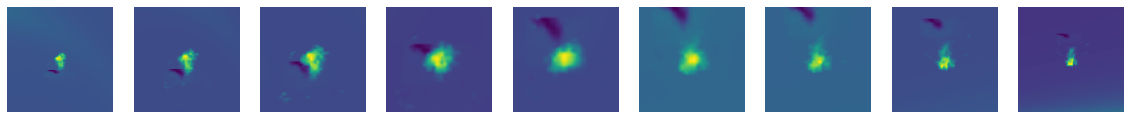

In [25]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
for ax, image in zip(axarr, images):
    ax.imshow(image)
    ax.invert_xaxis() 
    ax.invert_yaxis() 
    ax.axis('off')

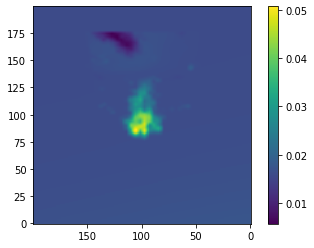

In [26]:
im = images[7]
plt.imshow(im)
plt.gca().invert_yaxis() 
plt.gca().invert_xaxis() 
plt.colorbar()


In [27]:
shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)

In [28]:
a,b,c = shdom.load_dynamic_forward_model(output_dir)
print()